# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [3]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [85]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [186]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
import time
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn_crfsuite import CRF

In [87]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

In [88]:
jsonFile = open('ingredient_and_quantity.json')
jsonData = json.load(jsonFile)
    
print(type(jsonFile))
print(jsonFile)

df = pd.DataFrame(jsonData)

<class '_io.TextIOWrapper'>
<_io.TextIOWrapper name='ingredient_and_quantity.json' mode='r' encoding='cp1252'>


In [89]:
# print first 5 rows
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [90]:
# describe the dataframe
print(df.describe())

                                                                                                                                                                                                  input                                                                                                                                                                                                                            pos
count                                                                                                                                                                                               285                                                                                                                                                                                                                            285
unique                                                                                                                                                    

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [91]:
# define a function to load json file to a dataframe
def loadJsonFile(jsonFilePath):
  jsonFile = open(jsonFilePath)
  jsonData = json.load(jsonFile)
  dfTemp = pd.DataFrame(jsonData)
  return dfTemp

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [92]:
# read the json file by giving the file path and create a dataframe
df = loadJsonFile('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [93]:
# display first five rows of the dataframe - df
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [94]:
# print the dimensions of dataframe - df
print(df.shape)

(285, 2)


In [95]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [96]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS

df['input_tokens'] = df['input'].apply(lambda x: x.split())
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [97]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [98]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_len'] = df['input_tokens'].apply(len)
df['pos_len'] = df['pos_tokens'].apply(len)
df[['input_tokens', 'input_len', 'pos_tokens', 'pos_len']].head()

input_tokens  input_len                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  pos_len
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]         31                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]       31
1                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]         34                                                                                                                                    [quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]       34
2                                                                           [1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]         37                                                                                                [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]       37
3  [500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]         46  [quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]       46
4                  

In [99]:
# check for the equality of input_length and pos_length in the dataframe
dfUnequalLen = df[df['input_len'] != df['pos_len']]
if len(dfUnequalLen) > 0:
  print("Mismatched length between input and pos")
  print(dfUnequalLen[['input_len', 'pos_len']].head())

Mismatched length between input and pos
     input_len  pos_len
17          15       14
27          37       36
79          38       37
164         54       53
207         18       17


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [100]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    #Fetch all labels
    allPosLabels = []
    for posList in df['pos_tokens']:
        allPosLabels.extend(posList)
        
    #Find unique labels
    uniquePosLabels = list(set(allPosLabels))
    
    return uniquePosLabels

allUniquePosLabels = unique_labels(df) #we should pass the original df and not the unequal one

for label in sorted(allUniquePosLabels):
    print(label)

ingredient
quantity
unit


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
There could be multiple indexes that require cleaning and formatting. For ex: 
1. Empty recipes or short recipes
2. Mismatch in input and pos lengths
3. Missing labels
4. Formatting errors - special characters, multiple spaces etc

We need to find specific indexes that are problematic and require cleanup, which we will do in the next step. But first we need to find those that are problematic - lets write some code to figure that out

In [101]:
# Find indexes that have mismatches in input and pos lengths
mismatchedLenIdx = df[df['input_len'] != df['pos_len']].index.tolist()

# Find indexes with empty/short recipes
emptyShortRecipeIdx = df[df['input_len'] < 4].index.tolist()

# Find indexes with missing labels. As there are only three unique pos labels, we expect all of those to be present 
# for all indexes. Any index missing even one is treated as problematic
missingLabelsIdx = []
for idx, row in df.iterrows():
    posTokens = row['pos_tokens']
    if not('ingredient'in posTokens and 'quantity' in posTokens and 'unit' in posTokens):
        missingLabelsIds.append(idx)
        
# Find indexes with formatting issues- use RegEx as appropriate
formatIssueIdx = []
for idx, row in df.iterrows():
    recipeText = row['input']
    #check for multiple spaces or special characters
    if re.search(r'\s{2,}', recipeText) or re.search(r'[^\w\s-]', recipeText):
        formatIssueIdx.append(idx)
        
# combine all problematic indexes
problematicIdx = list(set(mismatchedLenIdx + emptyShortRecipeIdx + missingLabelsIdx + formatIssueIdx))
problematicIdx.sort()

print(problematicIdx)


[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,

#### Looks like we have many problematic indexes, lets see those

In [102]:
def idProblems(idx):
    problems = []
    if idx in mismatchedLenIdx:
        problems.append("Length mismatch")
    if idx in emptyShortRecipeIdx:
        problems.append("Too short")
    if idx in missingLabelsIdx:
        problems.append("Missing labels")
    if idx in formatIssueIdx:
        problems.append("Formatting issues")
    return ', '.join(problems)

tempdf = df.loc[problematicIdx].copy()
tempdf['problems'] = tempdf.index.map(idProblems)
display_columns = ['input_len', 'pos_len', 'problems']
print(tempdf[display_columns])

print("\n=== PROBLEM DISTRIBUTION ===")
problem_counts = {
    'Length mismatch': len(mismatchedLenIdx),
    'Too short': len(emptyShortRecipeIdx),
    'Missing labels': len(missingLabelsIdx),
    'Formatting issues': len(formatIssueIdx)
}
maxCount = max(problem_counts.values())
for problem, count in problem_counts.items():
    bar = '█' * int((count / maxCount) * 30)
    print(f"{problem:<20} {bar} {count}")



     input_len  pos_len           problems
1           34       34  Formatting issues
2           37       37  Formatting issues
3           46       46  Formatting issues
5           41       41  Formatting issues
6           39       39  Formatting issues
..         ...      ...                ...
279         63       63  Formatting issues
280         32       32  Formatting issues
282         29       29  Formatting issues
283         44       44  Formatting issues
284         34       34  Formatting issues

[259 rows x 3 columns]

=== PROBLEM DISTRIBUTION ===
Length mismatch       5
Too short             0
Missing labels        0
Formatting issues    ██████████████████████████████ 259


#### our earlier count from "check for the equality of input_length and pos_length in the dataframe" matches with  the length mismatch that we found here. 
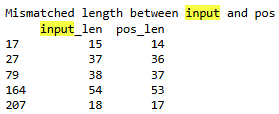

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [103]:
# drop the irrelevant recipe data
# From the above analysis, we see that all indexes with length mismatch can be dropped safely. However, indexes with formatting
# issues constitute a major chunk of the items - 259 of 284 recipes. Hence we should only drop those indexes that have a severe
# problem ie, mostly special characters, mostly empty etc

severeProbs= []
severeProbs.extend(mismatchedLenIdx)

for idx in formatIssueIdx:
    text = df.loc[idx, 'input']
    # Drop if >30% special characters or too short after cleaning
    if len(re.findall(r'[^\w\s-]', text)) > len(text) * 0.3:
        severeProbs.append(idx)
    else:
        cleanText = re.sub(r'[^\w\s-]', '', text).strip()
        if len(cleanText) < 10:
            severeProbs.append(idx)
            
# Remove any dups
severeProbs = list(set(severeProbs))

print(f"Total rows before dropping: {len(df)}")
print(f"Rows to be dropped: {len(severeProbs)}")
print(f"Percentage of data being dropped: {(len(severeProbs)/len(df))*100:.2f}%")

# Drop the problematic rows
dfCleaned = df.drop(index=severeProbs)

# Verify the drop
print(f"\nTotal rows after dropping: {len(dfCleaned)}")

# Reset the index to maintain continuity
dfCleaned = dfCleaned.reset_index(drop=True)

# Update the main dataframe
df = dfCleaned.copy()

Total rows before dropping: 285
Rows to be dropped: 5
Percentage of data being dropped: 1.75%

Total rows after dropping: 280


#### We see that none of the indexes with formatting issues were dropped. Good to go now

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [104]:
# update the input and pos length in input_length and pos_length
df['input_len'] = df['input_tokens'].apply(len)
df['pos_len'] = df['pos_tokens'].apply(len)

print(df[['input_len', 'pos_len']].head())
print(df[['input_len', 'pos_len']].describe())

   input_len  pos_len
0         31       31
1         34       34
2         37       37
3         46       46
4         21       21
        input_len     pos_len
count  280.000000  280.000000
mean    35.678571   35.678571
std     13.877481   13.877481
min      7.000000    7.000000
25%     26.000000   26.000000
50%     34.000000   34.000000
75%     43.000000   43.000000
max     93.000000   93.000000


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [105]:
# validate the input length and pos length as input_length and pos_length
unequalRows = df[df['input_len'] != df['pos_len']]
if len(unequalRows) == 0:
    print("\nAll rows have equal input and pos lengths")
else:
    print("\nRows with unequal length present ")


All rows have equal input and pos lengths


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [106]:
# split the dataset into training and validation sets
# we will do a 70:30 split
train_df, val_df = train_test_split(
    df, 
    test_size=0.3,      # 30% for validation
    train_size=0.7,     # 70% for training  
    random_state=23,
    shuffle=True        # Shuffle before splitting
)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [107]:
# print the first five rows of train_df
print(train_df.head())

                                                                                                                                                                                                                                                                                             input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos                                                                                                                                                                                                         

In [108]:
# print the first five rows of the val_df
print(val_df.head())

                                                                                                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                 

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [109]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
print(f"X_train length: {len(X_train)}")
print(f"X_val length: {len(X_val)}")

y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()
print(f"y_train length: {len(y_train)}")
print(f"y_val length: {len(y_val)}")



X_train length: 196
X_val length: 84
y_train length: 196
y_val length: 84


In [113]:
# validate the shape of training and validation samples
# check if the training the validation sets have the same length
print(f"Training set: X and y same length? {len(X_train) == len(y_train)}")
print(f"Validation set: X and y same length? {len(X_val) == len(y_val)}")

Training set: X and y same length? True
Validation set: X and y same length? True


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [114]:
# Display the number of unique labels present in y_train
y_train_labels = []
for item in y_train:
    y_train_labels.extend(item)
    
y_train_unique_labels = list(set(y_train_labels)) #If we put sort in the same line, none is the output. Hence next line
y_train_unique_labels.sort()
print(f"y_train_unique_labels: {y_train_unique_labels}")

y_train_unique_labels: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [115]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    flattened_list=[]
    for item in nested_list:
        flattened_list.extend(item)
        
    return flattened_list

In [116]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [118]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    input_token_list = df['input_tokens'].tolist()
    pos_token_list = df['pos_tokens'].tolist() 
    
    #use our function to flatten the token lists
    all_input_tokens = flatten_list(input_token_list)
    all_pos_tags = flatten_list(pos_token_list)
    
    print(f"Number of input tokens: {len(all_input_tokens)}")
    print(f"Number of POS tags: {len(all_pos_tags)}")
    
    if len(all_input_tokens) == len(all_pos_tags):
        print("Input and POS tokens length match")
    else:
        print("Input and POS tokens length dont match")
        
    for i in range(10):
        if i < len(all_input_tokens):
            print(f"{all_input_tokens[i]}: {all_pos_tags[i]}")
        
    return all_input_tokens, all_pos_tags


In [119]:
# extract the tokens and its pos tags
train_tokens_flattened, train_pos_flattened = extract_and_validate_tokens(train_df, dataset_name)

Number of input tokens: 7163
Number of POS tags: 7163
Input and POS tokens length match
1: quantity
cup: unit
rice: ingredient
12: quantity
small: unit
onions: ingredient
2: quantity
cloves: ingredient
garlic: ingredient
inch: unit


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [121]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorise_tokens(token_list, tag_list):
    token_categories = {
        'ingredients': [],
        'units': [],
        'quantities': []
    }
    
    # process each token-postag pair
    for idx in range(len(token_list)):
        current_token = token_list[idx]
        current_tag = tag_list[idx]
        
        # Sort into appropriate category
        if current_tag == "ingredient":
            token_categories['ingredients'].append(current_token)
        elif current_tag == "unit":
            token_categories['units'].append(current_token)
        elif current_tag == "quantity":
            token_categories['quantities'].append(current_token)
            
    return token_categories


In [165]:
#  call the function to categorise the labels into respective list
recipe_categories = categorise_tokens(train_tokens_flattened, train_pos_flattened)

for category, items in recipe_categories.items():
    item_count = len(items)
    print(f"{category}: {item_count} items")
    if item_count == 0:
        print(f"Category{category} not present")
    

ingredients: 5352 items
units: 832 items
quantities: 979 items


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [126]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, maxitems=10):
    item_counts = Counter(item_list)
    top_items = item_counts.most_common(maxitems)
    
    return top_items

In [128]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(recipe_categories['ingredients'])
for i in range(len(top_ingredients)):
    item, count = top_ingredients[i]
    print(f"{i+1}. {item}: {count}")

1. powder: 127
2. Salt: 106
3. seeds: 92
4. Oil: 89
5. Red: 87
6. Green: 85
7. chopped: 83
8. Chilli: 80
9. Coriander: 75
10. Leaves: 69


In [129]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(recipe_categories['units'])
for i in range(len(top_units)):
    item, count = top_units[i]
    print(f"{i+1}. {item}: {count}")

1. teaspoon: 154
2. cup: 139
3. tablespoon: 98
4. tablespoons: 67
5. grams: 55
6. inch: 53
7. sprig: 49
8. cups: 44
9. cloves: 41
10. teaspoons: 36


In [139]:
# get the top quantities which are frequently seen in the recipe
top_qtys = get_top_frequent_items(recipe_categories['quantities'])
for i in range(len(top_qtys)):
    item, count = top_qtys[i]
    print(f"{i+1}. {item}: {count}")

1. 1: 190
2. 2: 154
3. 1/2: 144
4. 1/4: 90
5. 3: 70
6. 4: 64
7. 1-1/2: 24
8. 3/4: 17
9. 10: 17
10. 6: 17


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [136]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_item_list, label, dataset_name):
    items= []
    counts = []
    
    #Loop through top items and separate names from counts
    for item_pair in top_item_list:
        items.append(item_pair[0])
        counts.append(item_pair[1])
        
    plt.figure(figsize=(10, 6))
    bars = plt.bar(items, counts, color='skyblue')
    
    #Add count labels to the bars
    plt.bar_label(bars, labels=[str(c) for c in counts], padding=3)
    
    #Customise further
    plt.xlabel('Frequency')
    plt.ylabel(label.capitalize())
    plt.title(f'Top {len(top_item_list)} {label}s in {dataset_name} Dataset')
    plt.tight_layout()
    
    #Show the plot
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



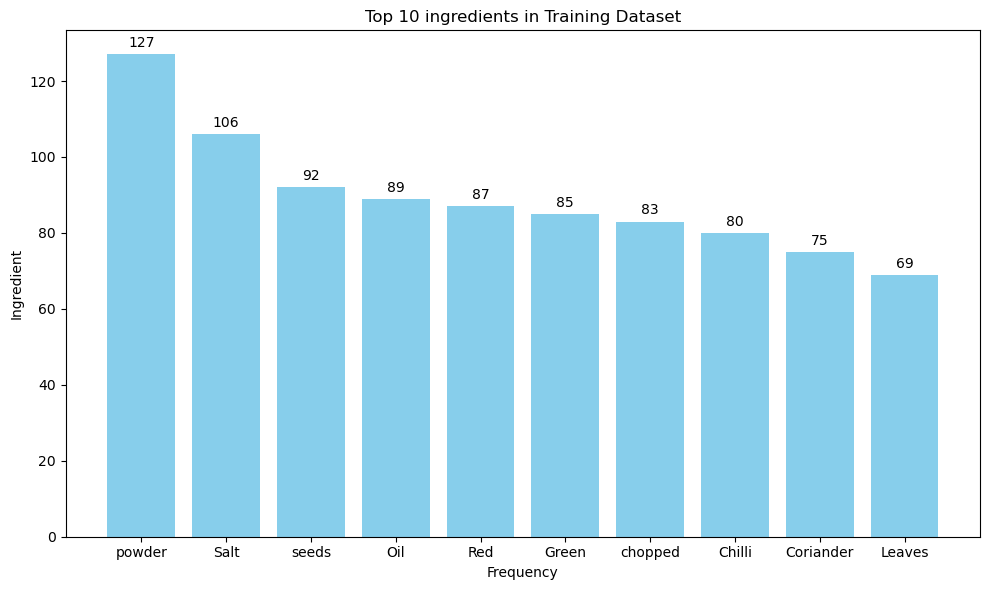

In [137]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, 'ingredient', dataset_name)

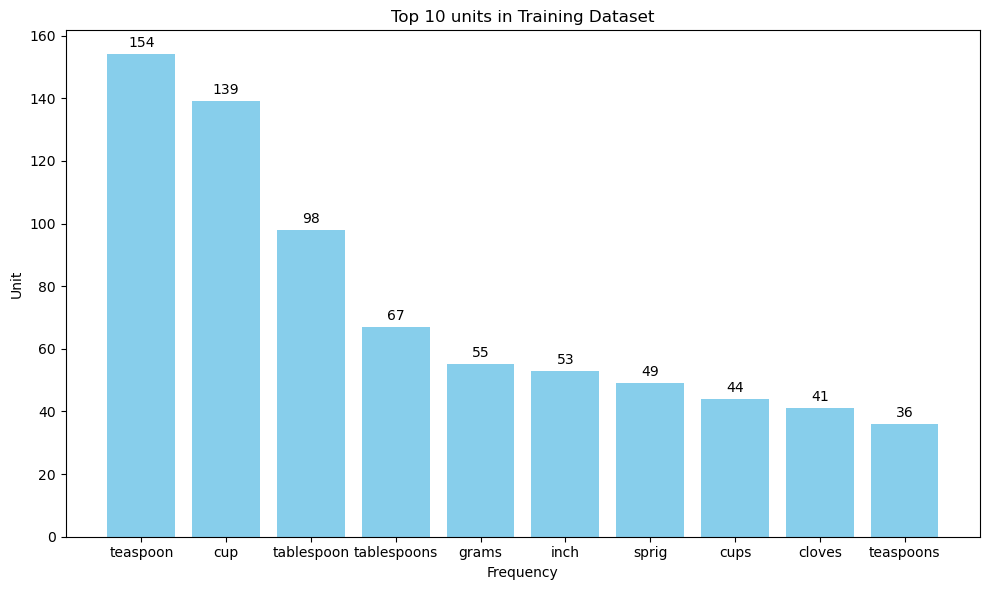

In [138]:
# plot the top frequent units in training data
plot_top_items(top_units, 'unit', dataset_name)

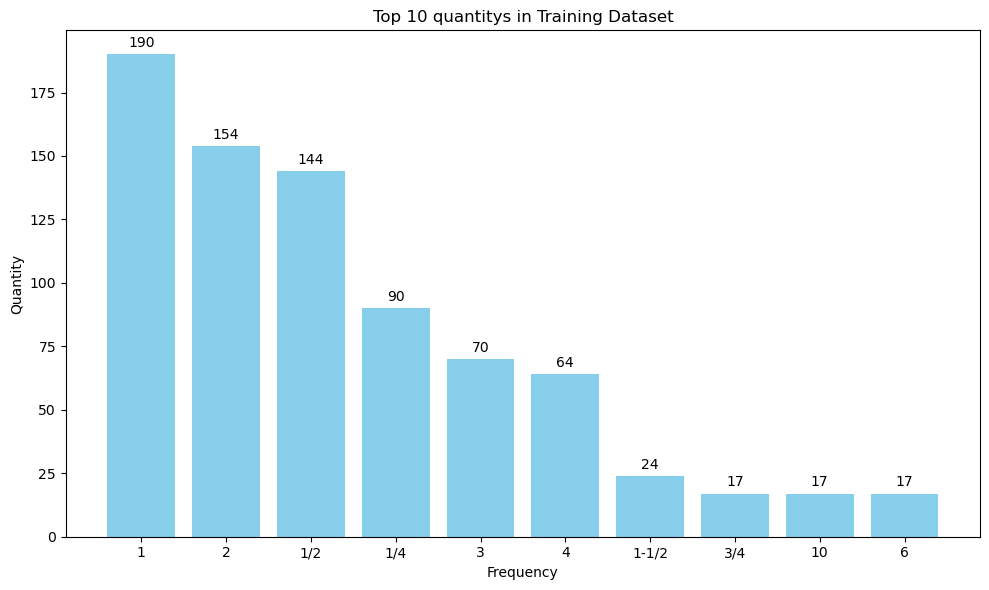

In [140]:
# plot the top frequent quantities in training data
plot_top_items(top_qtys, 'quantity', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [141]:
# define unit and quantity keywords along with quantity pattern
# we define unit and quantity keywords by including the most freqently appearing ones (from our earlier analysis), their variants
# and searching for others to include the relevant ones. There is a chance that we may not include all relevant ones and this
# can end up affecting our result

# Define unit keywords
unit_keywords = ["teaspoon", "teaspoons", "tsp", "cup", "cups", "tablespoon", "tablespoons", "tbsp", "gram", "grams", "g", 
                   "kilogram", "kg", "kilo", "inch", "inches", "sprig", "sprigs", "clove", "cloves", "ounce", "oz", "ounces",
                   "pound", "lb", "lbs", "pounds", "ml", "milliliter", "millilitre", "milliliters", "millilitres", "liter", 
                   "litre", "l", "liters", "litres", "small", "medium", "large", "bunch", "bunches", "pinch", "pinches", 
                   "piece", "pieces", "spoon", "spoons", "cm", "cms", "centimeters"
                ]

# Define quantity keywords
quantity_keywords = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "twenty", "twentyfive"             
                     "half", "halves", "quarter", "quarters", "third", "thirds", 
                     "one half", "one third", "one quarter", "one fourth", "two thirds", "two quarters", "three quarters", 
                     "three fourths", "one and a half", "one and a quarter", "two and a half",
                     "dozen", "whole", "few", "little", "some", "handful", "several", "couple", "pair"
                    ]

quantity_pattern = r'(\d+\s+\d+\/\d+|\d+\-\d+\/\d+|\d+\s+and\s+\d+\/\d+|\d+\/\d+|\d+\.\d+|\d+)'

In [149]:
# load spaCy model
nlp = spacy.load('en_core_web_sm') #,disable=['parser','ner'])

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [159]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

from spacy.matcher import Matcher

def word2features(sent, i):
    word = sent[i]
    sentence = " ".join([str(token) for token in sent])
    doc = nlp(sentence)
    
    # Process the entire sentence with spaCy
                       
    # --- Core Features ---
    features = {
        'bias': 1.0,                  # constant feature
        'token': word.lower(),        # lowercase form of token
        'is_digit': word.isdigit(),   # only digits
        'has_digit': any(c.isdigit() for c in word),  # contains digit
        'has_alpha': any(c.isalpha() for c in word),  # contains alphabetic character
        'hyphenated': '-' in word,    # contains hyphen
        'slash_present': '/' in word, # contains slash
        'is_title': word.istitle(),   # starts with uppercase
        'is_upper': word.isupper(),   # fully uppercase
        'is_punct': all(not c.isalnum() for c in word)  # Punctuation
    }
    
    # Find matching spaCy token - simpler approach to avoid errors
    spacy_token = None
    for token in doc:
        if token.text.lower() == word.lower():
            spacy_token = token
            break       
    
     # Add spaCy features if token was found
    if spacy_token:
        features['lemma'] = spacy_token.lemma_.lower() # lowercase lemma
        features['pos_tag'] = spacy_token.pos_ # pos tag
        features['tag'] = spacy_token.tag_     # detailed pos tag
        features['dep'] = spacy_token.dep_     # dependency relation
        features['shape'] = spacy_token.shape_ # token shape
        features['is_stop'] = spacy_token.is_stop # stopword
        
        
    # --- Improved Quantity & Unit Detection ---
    features['is_quantity'] = (word.lower() in quantity_keywords or bool(re.match(quantity_pattern, word))) # matches qty pattern
    features['is_unit'] = word.lower() in unit_keywords          # known measurement unit
    features['is_numeric'] = bool(re.match(r'^\d+$', word))      # matches number
    features['is_fraction'] = bool(re.match(r'^\d+/\d+$', word)) # fraction
    features['is_decimal'] = bool(re.match(r'^\d+\.\d+$', word)) # decimal number
    
    # Add previous and next word features
    if i > 0:
        features['preceding_word'] = sent[i-1] # prev token
    if i < len(sent) - 1:
        features['following_word'] = sent[i+1] # next token

    # --- Contextual Features ---
    # Beginning/End of Sequence
    features['BOS'] = (i == 0)
    features['EOS'] = (i == len(sent) - 1)
    
    # Previous token features
    if i > 0:
        prev_word = sent[i-1]
        features['prev_token'] = prev_word.lower()
        features['prev_is_quantity'] = (prev_word.lower() in quantity_keywords or bool(re.match(quantity_pattern, prev_word)))
        features['prev_is_digit'] = prev_word.isdigit()
    else:
        features['prev_token'] = '<START>'
        
    # Next token features
    if i < len(sent) - 1:
        next_word = sent[i+1]
        features['next_token'] = next_word.lower()
        features['next_is_unit'] = next_word.lower() in unit_keywords
        features['next_is_ingredient'] = not (next_word.lower() in unit_keywords or next_word.lower() in quantity_keywords or 
                                           bool(re.match(quantity_pattern, next_word)))
    else:
        features['next_token'] = '<END>'
        
    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [160]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    # Process each token in the sentence by extracting custom features
    recipe_features = []
    
    for idx in range(len(sent)):
        # Extract features for this token using our feature function
        token_features = word2features(sent, idx)
        
        # Append to feature list for this recipe
        recipe_features.append(token_features)
        
    return recipe_features

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [161]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
from tqdm import tqdm

def convert_input_sent_2_feature_sets(X_dataset, dataset_name):
    features_list = []
    
    # iterate thru all recipes
    for recipe_idx, recipe_tokens in tqdm(enumerate(X_dataset)):
        # Extract features for the recipe
        recipe_features = sent2features(recipe_tokens)
        features_list.append(recipe_features)
        
    return features_list

# Create feature sets for training and validation data
X_train_features = convert_input_sent_2_feature_sets(X_train, "training")
X_val_features = convert_input_sent_2_feature_sets(X_val, "validation")

196it [01:08,  2.88it/s]
84it [00:25,  3.36it/s]


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [164]:
# Convert labels into list as y_train_labels and y_val_labels
def convert_label_2_list(y_dataset, dataset_name):
    formatted_labels = []
    
    # Check labels in each recipe
    for idx, label_sequence in tqdm(enumerate(y_dataset)):
        string_labels = [str(label) for label in label_sequence]
        formatted_labels.append(string_labels)
        
    return formatted_labels

# Create label lists for training and validation data
y_train_labels = convert_label_2_list(y_train, "training")
y_val_labels = convert_label_2_list(y_val, "validation")

196it [00:00, 189071.66it/s]
84it [00:00, 83946.04it/s]


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [166]:
# print the length of train features and labels
print(f"Length of X_train_features: {len(X_train_features)} & Length of y_train_labels: {len(y_train_labels)}")

Length of X_train_features: 196 & Length of y_train_labels: 196


In [167]:
# print the length of validation features and labels
print(f"Length of X_val_features: {len(X_val_features)} & Length of y_val_labels: {len(y_val_labels)}")

Length of X_val_features: 84 & Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [169]:
# Flatten labels in y_train
y_train_flat = []

# Loop thru recipes in y_train
cnt = 0
for labels in y_train_labels:
    y_train_flat.extend(labels)
    cnt += 1
    
print(y_train_flat)

['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'qu

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [172]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = {}

# Count frequency of each label 
for label in y_train_flat:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1
        
total_samples = sum(label_counts.values())

print(label_counts)
print(total_samples)

{'quantity': 979, 'unit': 832, 'ingredient': 5352}
7163


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [176]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}

# Calculate inverse frequency for each label
for label, count in label_counts.items():
    weight = total_samples / (len(label_counts) * count)
    weight_dict[label] = weight

print(weight_dict)

{'quantity': 2.4388832141641132, 'unit': 2.8697916666666665, 'ingredient': 0.44612605879422024}


In [177]:
# penalise ingredient label
# penalisation here means giving more importance during training. We penalise ingredient as those are the most important in 
# recipes
# Since penalisation factor is not given, we assume 25%
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= 1.25

print(weight_dict)

{'quantity': 2.4388832141641132, 'unit': 2.8697916666666665, 'ingredient': 0.5576575734927753}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [183]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X_features, y_labels, class_weights):
    if len(X_features) != len(y_labels):
        print("Mismatch between features and labels")
        return
    else:
        weighted_dataset = {
            'X': X_features,
            'y': y_labels,
            'weights': []
            }
        # Apply weights 
        for idx, labels in enumerate(y_labels):
            # Get weights for this recipe's labels
            weights = []
            for label in labels:
                # Use the label's weight. Use 1.0 if not present
                weight = class_weights.get(label, 1.0)
                weights.append(weight)
        
            # Add to dataset
            weighted_dataset['weights'].append(weights)
            
            return weighted_dataset

weighted_features = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)

# printing weighted_features results in a IOPub data rate exceeded error
#print(weighted_features)


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [184]:
# Apply manually computed class weights
train_weighted = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)
val_weighted = extract_features_with_class_weights(X_val_features, y_val_labels, weight_dict)

# Create X_train_weighted_features and X_val_weighted_features
X_train_weighted_features = train_weighted['X']
X_val_weighted_features = val_weighted['X']

print(f"Training set: {len(X_train_weighted_features)} recipes")
print(f"Validation set: {len(X_val_weighted_features)} recipes")

Training set: 196 recipes
Validation set: 84 recipes


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [189]:
# Store training start time
training_start = time.time()

# initialise CRF model with the specified hyperparameters and use weight_dict
crf_model = CRF(
                algorithm='lbfgs',        # Limited-memory BFGS algorithm
                c1=0.5,                   # L1 regularization (sparsity control in feature weights)
                c2=1.0,                   # L2 regularization (prevents overfitting by penalisation)
                max_iterations=100,       # Training iterations limit
                all_possible_transitions=True,  # Consider all state transitions
                verbose=True              # Show training progress
                )
crf_model.class_weight = weight_dict

# train the CRF model with the weighted training data
crf_model.fit(X_train_weighted_features, y_train_labels)

training_duration = time.time() - training_start

print(f"Training completed in {training_duration:.2f} seconds")
    

loading training data to CRFsuite: 100%|██████████| 196/196 [00:00<00:00, 2627.77it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 6347
Seconds required: 0.032

L-BFGS optimization
c1: 0.500000
c2: 1.000000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.01  loss=3807.35  active=5765  feature_norm=1.00
Iter 2   time=0.01  loss=3036.92  active=4216  feature_norm=1.10
Iter 3   time=0.01  loss=1394.52  active=3631  feature_norm=2.20
Iter 4   time=0.01  loss=1060.49  active=3166  feature_norm=2.66
Iter 5   time=0.01  loss=761.26   active=2818  feature_norm=3.52
Iter 6   time=0.01  loss=584.33   active=2228  feature_norm=4.40
Iter 7   time=0.00  loss=494.88   active=1748  feature_norm=5.27
Iter 8   time=0.01  loss=468.01   active=1593  feature_norm=5.81
Iter 9   time=0.01  loss=453.13   active=1542  feature_norm=5.94
Iter 10  time=0

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [191]:
# evaluate on the training dataset
# Make predictions
y_predicted = crf_model.predict(X_train_weighted_features)

In [192]:
# specify the flat classification report by using training data for evaluation
y_true_flat = [label for seq in y_train_labels for label in seq]
y_predicted_flat = [label for seq in y_predicted for label in seq]

In [206]:
# create a confusion matrix on training datset
# Get unique labels for confusion matrix
labels = sorted(list(set(y_true_flat)))

# Generate classification report
report = flat_classification_report(y_train_labels, y_predicted, labels=labels, digits=4)
    
# Create confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_predicted_flat, labels=labels)   

# Display confusion matrix
conf_df = pd.DataFrame(conf_matrix, index=[f'True_{l}' for l in labels], columns=[f'Pred_{l}' for l in labels])

# Calculate overall accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
   

print(f"\nConfusion Matrix ({dataset_name} data):")
print(conf_df)

print(f"\nOverall Accuracy: {accuracy:.4f}")
    
print(f"\nTraining Classification Report ({dataset_name} data):")
print(report)



Confusion Matrix (Training data):
                 Pred_ingredient  Pred_quantity  Pred_unit
True_ingredient             5336              1         15
True_quantity                 16            961          2
True_unit                     40              0        792

Overall Accuracy: 0.9897

Training Classification Report (Training data):
              precision    recall  f1-score   support

  ingredient     0.9896    0.9970    0.9933      5352
    quantity     0.9990    0.9816    0.9902       979
        unit     0.9790    0.9519    0.9653       832

    accuracy                         0.9897      7163
   macro avg     0.9892    0.9768    0.9829      7163
weighted avg     0.9897    0.9897    0.9896      7163



### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [195]:
# dump the model using joblib as crf_model.pkl
import joblib
import os
from datetime import datetime

# Create directory if it doesn't exist
if not os.path.exists('crf-models'):
    os.makedirs('crf-models')

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"id_keyentity_in_recipes_{timestamp}.pkl"

# Prep full path
model_path = os.path.join('crf-models', filename)

# Save model
joblib.dump(crf_model, model_path)
print(f"Model saved to {model_path}")

Model saved to crf-models\id_keyentity_in_recipes_20250512_1835.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [196]:
# predict the crf model on validation dataset
print("Evaluation on vaildation set")
y_val_predicted = crf_model.predict(X_val_weighted_features)


Evaluation on vaildation set


In [203]:
# specify flat classification report
# Extract all labels 
all_labels = set()
for seq in y_val_labels:
    all_labels.update(seq)
label_list = sorted(list(all_labels))

# Create classification report
val_report = flat_classification_report(
                                        y_val_labels, 
                                        y_val_predicted,
                                        labels=label_list,
                                        digits=4,
                                        )                                     

print(f"\nValidation Classification Report:")
print(val_report)




Validation Classification Report:
              precision    recall  f1-score   support

  ingredient     0.9923    0.9933    0.9928      2078
    quantity     0.9927    0.9854    0.9890       412
        unit     0.9675    0.9703    0.9689       337

    accuracy                         0.9894      2827
   macro avg     0.9841    0.9830    0.9836      2827
weighted avg     0.9894    0.9894    0.9894      2827



In [205]:
# create a confusion matrix on validation dataset
# Flatten predictions and true labels
y_val_true_flattened = [label for seq in y_val_labels for label in seq]
y_val_pred_flattened = [label for seq in y_val_predicted for label in seq]
    
# Generate confusion matrix
conf_matrix = confusion_matrix(y_val_true_flattened, y_val_pred_flattened, labels=label_list)
    
conf_df = pd.DataFrame(conf_matrix, index=[f'True: {label}' for label in label_list], 
                       columns=[f'Pred: {label}' for label in label_list]
                        )
    
print("\nValidation Confusion Matrix:")
print(conf_df)

# Calculate overall accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f"\nOverall Accuracy: {accuracy:.4f}")


Validation Confusion Matrix:
                  Pred: ingredient  Pred: quantity  Pred: unit
True: ingredient              2064               3          11
True: quantity                   6             406           0
True: unit                      10               0         327

Overall Accuracy: 0.9894


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.